# Validation experiment - NARMAX

## Data

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, with the parameter $\tau$ representing the precision of the process. Measurement noise is also Wiener, with $\gamma$ as precision.

In [1]:
using CSV
using MAT
using JLD
using DataFrames

In [2]:
using Plots
pyplot();

In [3]:
# Read data from CSV file
df = CSV.read("silverbox-data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
# Select training set
ix_trn = Array{Int64,1}(4.05*1e4:131072)
input_trn = input[ix_trn]
output_trn = output[ix_trn]

# Select validation set
ix_tst = Array{Int64,1}(1e3:(4.05*1e4-1))
input_tst = input[ix_tst]
output_tst = output[ix_tst];

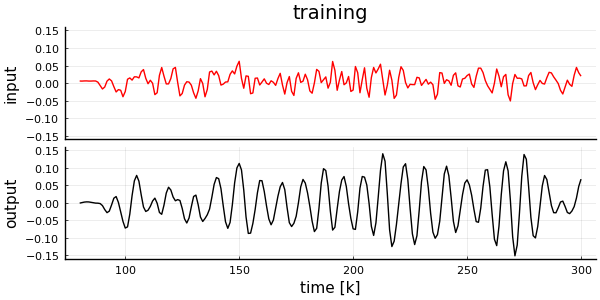

In [5]:
# Plot every n-th time-point to avoid figure size exploding
zoom_t = 80:300

p1a = Plots.plot(zoom_t, input_trn[zoom_t], color="red", label="", markersize=2, xticks=:none, xlabel="", ylabel="input", title="training")    
p1b = Plots.plot(zoom_t, output_trn[zoom_t], color="black", label="", markersize=2, xlabel="time [k]", ylabel="output")    
p1 = plot(p1a, p1b, layout=(2,1), ylims=[-0.15, 0.15], size=(600,300))
#     Plots.savefig(p1, "figures/training_set.png")

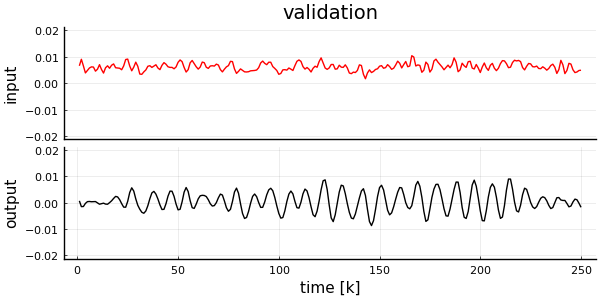

In [6]:
zoom_t = 1:250

p2a = plot(zoom_t, input_tst[zoom_t], color="red", label="", markersize=2, xticks=:none, xlabel="", ylabel="input", title="validation")    
p2b = plot(zoom_t, output_tst[zoom_t], color="black", label="", markersize=2, xlabel="time [k]", ylabel="output")    
p2 = plot(p2a, p2b, layout=(2,1), ylims=[-0.02, 0.02], size=(600,300))
#     Plots.savefig(p2, "figures/validation_set.png")

## NARMAX

A NARMAX model sports the following set of dynamics:

$$\begin{align}
y_k =&\ f_\theta(u_k, u_{k-1}, \dots, u_{k-M_1}, y_{k-1}, \dots, y_{k-M_2},  e_{k-1}, \dots, e_{k-M_3})  + e_k
\end{align}$$

where $M_1$ is the number of input delays, $M_2$ the number of output delays and $M_3$ the number of error delays. The error term $e_k$ is assumed to follow zero-mean zero-autocorrelation white noise: $e_k \sim \mathcal{N}(0, \tau^{-1})$.

I'm going to concatenate terms into a vector as follows:
$$\begin{align*}
{\bf u}_{k-1} = \begin{bmatrix} u_{k-1} \\ \vdots \\ u_{t-M1} \end{bmatrix} \, , \quad 
{\bf y}_{k-1} = \begin{bmatrix} y_{k-1} \\ \vdots \\ y_{t-M2} \end{bmatrix} \, , \quad 
{\bf e}_{k-1} = \begin{bmatrix} e_{k-1} \\ \vdots \\ e_{t-M3} \end{bmatrix} \, .
\end{align*}$$

Plugging these in, I get the following shorter function:

$$\begin{align}
y_k =&\ f_\theta(u_k, {\bf u}_{k-1}, {\bf y}_{k-1}, {\bf e}_{k-1})  + e_k
\end{align}$$

## Free Energy Minimisation

### Likelihood

Integrating out $e_k$ produces a Gaussian node:

$$y_k \sim \mathcal{N}(f_\theta(u_k, {\bf u}_{k-1}, {\bf y}_{k-1}, {\bf e}_{k-1}), \tau^{-1}) \, .$$

We can approximate the nonlinearity $f$ around $\theta$ through a Taylor series:

$$f_\theta(u_k, {\bf u}_{k-1}, {\bf y}_{k-1}, {\bf e}_{k-1}) \approx f_{\mu}(u_k, {\bf u}_{k-1}, {\bf y}_{k-1}, {\bf e}_{k-1}) + J_{k}^{\top}(\theta - \mu)$$

where $J_{k} = \frac{d f_\theta}{d \theta} \big\vert_{\theta = \mu}$. The Jacobian can be obtained automatically using Julia packages such as [Zygote.jl](https://github.com/FluxML/Zygote.jl). 


### Priors

We currently have unknown parameters $\theta$ and $\tau$. The coeffients can be both positive and negative, so we will opt for a Gaussian prior. The prior for a precision parameter $\tau$ will be a Gamma distribution.

$$\begin{align}
p(\theta) =&\ \text{Normal}(\theta \mid \mu_0, \Lambda_{0}) \\
p(\tau) =&\ \text{Gamma}(\tau \mid \alpha_{0}, \beta_{0}) \, .
\end{align}$$

### Recognition factors

We choose the simplest possible recognition model, a mean-field factorisation of both unknown variables:

$$\begin{align}
q_k(\theta) =&\ \text{Normal}(\theta \mid \mu_k, \Lambda_k) \\
q_k(\tau) =&\ \text{Gamma}(\tau \mid \alpha_k, \beta_k) \, .
\end{align}$$

Note that the generative and recognition model match, which means the KL-divergence between the generative and recognition model can potentially be driven to $0$.

### Implementation

We implement this model with the toolbox ForneyLab.jl and a custom NARMAX node.

In [7]:
using ProgressMeter
using LinearAlgebra
using ForneyLab

import ForneyLab: unsafeMean, unsafeCov, unsafePrecision

In [8]:
using NARMAX

In [9]:
# Start graph
graph = FactorGraph()

# Autoregression orders
M1 = 3
M2 = 3
M3 = 3
M = 1 + M1 + M2 + M3

# Basis expansion
degree = 3
Φ = zeros(M,1); for d=1:degree; Φ = hcat(d .*Matrix{Float64}(I,M,M), Φ); end
ϕ(x::Array{Float64,1}) = [prod(x.^Φ[:,k]) for k = 1:size(Φ,2)]

# Number of parameters
num_coeffs = size(Φ,2)

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:μ, dims=(num_coeffs,)), placeholder(:Λ, dims=(num_coeffs, num_coeffs)))
@RV τ ~ Gamma(placeholder(:α), placeholder(:β))

# Setup observation and input vectors
@RV u_k
@RV u_kmin1
@RV y_kmin1
@RV e_kmin1

# NARMAX node
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)

# Mark placeholders for observation
placeholder(y_k, :y_k)
placeholder(u_k, :u_k)
placeholder(u_kmin1, :u_kmin1, dims=(M1,))
placeholder(y_kmin1, :y_kmin1, dims=(M2,))
placeholder(e_kmin1, :e_kmin1, dims=(M3,))

# Draw time-slice subgraph
# ForneyLab.draw(graph)

# Define variational message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ, :τ])
algo = messagePassingAlgorithm(free_energy=true)

# Compile and import compiled functions
source_code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(source_code));
# println(source_code)

### Estimate parameters

In [10]:
# Maximum delay
maxM = maximum([M1,M2,M3])

# Zero-padding of signals for delay indexing
input_trn = [zeros(maxM,); input_trn]
input_tst = [zeros(maxM,); input_tst]
output_trn = [zeros(maxM,); output_trn]
output_tst = [zeros(maxM,); output_tst]

# Signal splits
T_trn = length(input_trn)
T_tst = length(input_tst);

In [11]:
# Set prior parameters
θ_k = (zeros(num_coeffs,), 1. .*Matrix{Float64}(I,num_coeffs, num_coeffs))
τ_k = (1e4, 1e0);

In [12]:
# Number of VMP iterations
num_iters = 5

# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_k[1], w=θ_k[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

# Preallocate free energy array
Fq = zeros(T_trn-maxM, num_iters)

# Preallocate parameter arrays
params_θ = (zeros(T_trn-maxM,num_coeffs), zeros(T_trn-maxM,num_coeffs,num_coeffs))
params_τ = (zeros(T_trn-maxM,1), zeros(T_trn-maxM,1))

# Preallocate prediction arrays
predictions = (zeros(T_trn,), zeros(T_trn,))
errors = zeros(T_trn,)

@showprogress for (ii,k) in enumerate(maxM+1:T_trn)

    # Update history vectors
    u_kmin1 = input_trn[k-1:-1:k-M1]
    y_kmin1 = output_trn[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions[1][k] = θ_k[1]'*ϕx
    predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

    # Compute prediction error
    errors[k] = output_trn[k] - predictions[1][k]

    # Set data 
    data = Dict(:y_k => output_trn[k],
                :u_k => input_trn[k],
                :u_kmin1 => u_kmin1,
                :y_kmin1 => y_kmin1,
                :e_kmin1 => e_kmin1,
                :μ => θ_k[1],
                :Λ => θ_k[2],
                :α => τ_k[1],
                :β => τ_k[2])

    # Iterate updates
    for n = 1:num_iters

        # Compute free energy
        Fq[ii,n] = freeEnergy(data,marginals)

        # Update parameters
        stepθ!(data, marginals)
        stepτ!(data, marginals)

    end 

    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])

    # Store params
    params_θ[1][ii,:] = θ_k[1]
    params_θ[2][ii,:,:] = θ_k[2]
    params_τ[1][ii] = τ_k[1]
    params_τ[2][ii] = τ_k[2]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:11:42:17


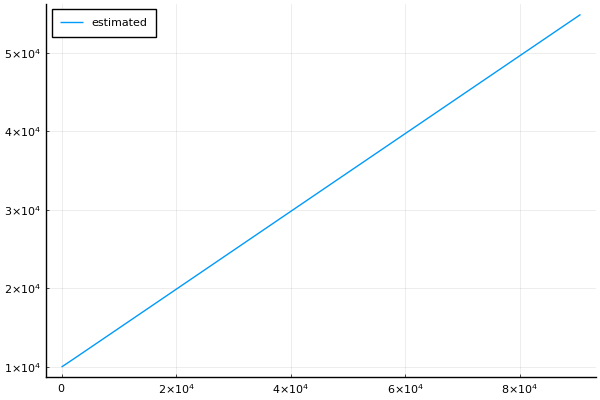

In [13]:
mτ = params_τ[1] ./ params_τ[2]

plot(maxM+1:T_trn, mτ, labels="estimated")

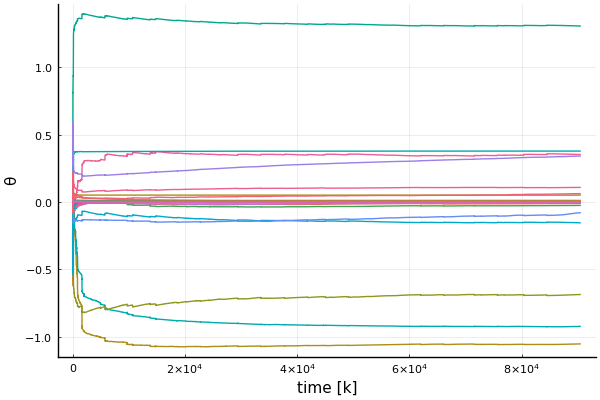

In [14]:
plot(params_θ[1], xlabel="time [k]", ylabel="θ", labels="")

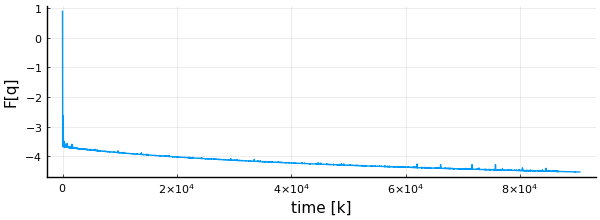

In [15]:
plot(maxM+1:T_trn, Fq[:,end], label="", xlabel="time [k]", ylabel="F[q]", size=(600,220))

### 1-step ahead prediction error

In [16]:
# Prepare array
predictions_FEM = (zeros(T_tst,), zeros(T_tst,))
errors = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = output_tst[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])

    # Update error
    errors[k] = output_tst[k] - predictions_FEM[1][k]

end

sqerrors_prd_FEM = (predictions_FEM[1] .- output_tst).^2
RMS_prd_FEM = sqrt(mean(sqerrors_prd_FEM))

0.00022961847059224883

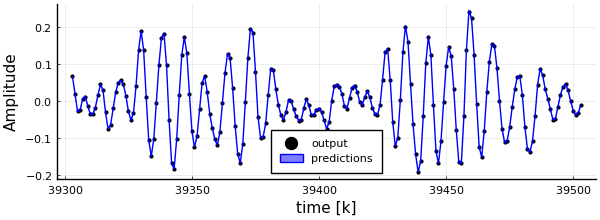

In [17]:
zoom_t = T_tst-200:T_tst

std = sqrt.(predictions_FEM[2][zoom_t])

p3a = scatter(zoom_t, output_tst[zoom_t], color="black", label="output", markersize=2, xlabel="time [k]", ylabel="Amplitude")
plot!(zoom_t, predictions_FEM[1][zoom_t], ribbon=[std, std], color="blue", linewidth=1, label="predictions", size=(600,220))

In [18]:
savefig(p3a, "figures/silverbox-NARMAX-FEM-1predictions_zoom"*string(zoom_t)*".png")

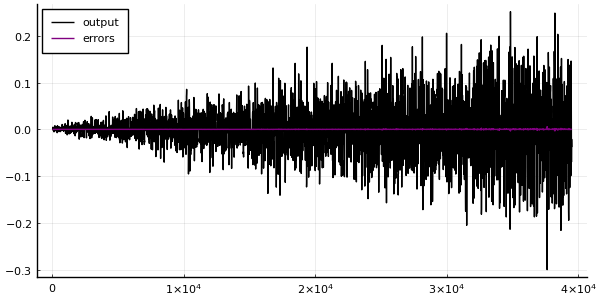

In [19]:
zoom_t = 1:10:T_tst

errors = output_tst .- predictions_FEM[1]

p3b = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, label="output")
plot!(zoom_t, errors[zoom_t], color="purple", linewidth=1, label="errors", size=(600,300))

In [20]:
savefig(p3b, "figures/silverbox-NARMAX-FEM-1predictions_errors_zoom"*string(zoom_t)*".png")

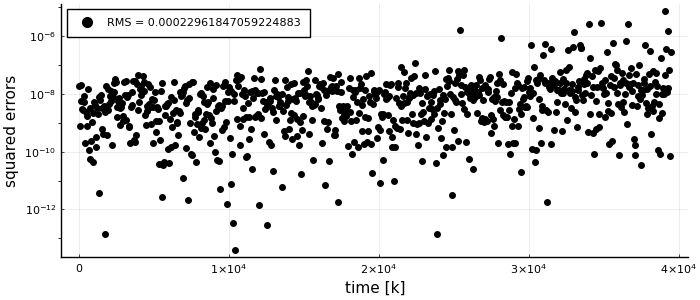

In [21]:
zoom_t = 10:50:T_tst

p3c = scatter(zoom_t, 
             sqerrors_prd_FEM[zoom_t], 
             color="black", 
             markersize=4, 
             size=(700,300), 
             xlabel="time [k]", 
             ylabel="squared errors",
             labels="RMS = "*string(RMS_prd_FEM),
             yscale=:log10)

In [22]:
savefig(p3c, "figures/silverbox-NARMAX-FEM-1predictions_sqerrors_zoom"*string(zoom_t)*".png")

### Simulation error

In [23]:
# Prepare array
simulations_FEM = (zeros(T_tst,), zeros(T_tst,))

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = simulations_FEM[1][k-1:-1:k-M2]
    e_kmin1 = zeros(M3,)

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    simulations_FEM[1][k] = θ_k[1]'*ϕx
    simulations_FEM[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])

end

sqerrors_sim_FEM = (simulations_FEM[1] .- output_tst).^2
RMS_sim_FEM = sqrt(mean(sqerrors_sim_FEM))

0.0016386402996618895

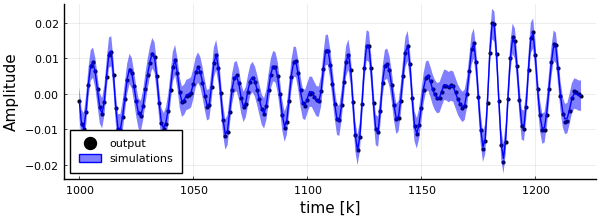

In [24]:
zoom_t = 1000:1220

std = sqrt.(simulations_FEM[2][zoom_t])

p4a = scatter(zoom_t, output_tst[zoom_t], color="black", label="output", markersize=2, xlabel="time [k]", ylabel="Amplitude")
plot!(zoom_t, simulations_FEM[1][zoom_t], ribbon=[std, std], color="blue", linewidth=1, label="simulations", size=(600,220))

In [25]:
savefig(p4a, "figures/silverbox-NARMAX-FEM-simulations_zoom"*string(zoom_t)*".png")

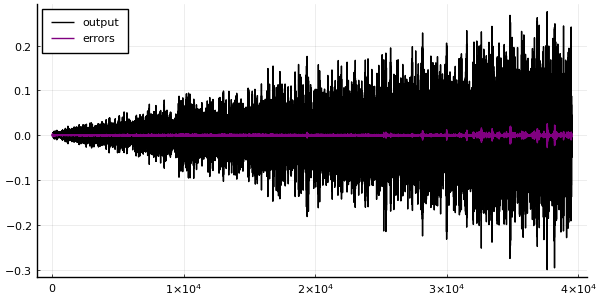

In [26]:
zoom_t = 1:T_tst

errors = output_tst .- simulations_FEM[1]

p4b = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, label="output")
plot!(zoom_t, errors[zoom_t], color="purple", linewidth=1, label="errors", size=(600,300))

In [27]:
savefig(p4b, "figures/silverbox-NARMAX-FEM-simulations_errors_zoom"*string(zoom_t)*".png")

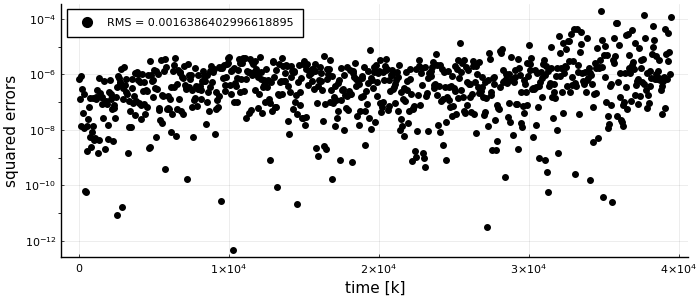

In [28]:
zoom_t = 10:50:T_tst

p4c = scatter(zoom_t, 
              sqerrors_sim_FEM[zoom_t], 
              color="black", 
              markersize=4, 
              size=(700,300), 
              xlabel="time [k]", 
              ylabel="squared errors",
              labels="RMS = "*string(RMS_sim_FEM),
              yscale=:log10)

In [29]:
savefig(p4c, "figures/silverbox-NARMAX-FEM-simulations_sqerrors_zoom"*string(zoom_t)*".png")

In [30]:
# Write results to file
save("results/silverbox-NARMAX-FEM_order"*string(M)*"_results.jld", 
     "params_θ", params_θ, 
     "params_τ", params_τ,
     "Fq", Fq,
     "simulations_FEM", simulations_FEM, 
     "predictions_FEM", predictions_FEM,
     "RMS_sim_FEM", RMS_sim_FEM,
     "RMS_prd_FEM", RMS_prd_FEM)

## Baseline: Recursive least-squares

### Estimate parameters

In [31]:
# Forgetting factor
λ = 1.0

# Parameters
P = λ.*Matrix{Float64}(I,num_coeffs,num_coeffs)
w_k = zeros(num_coeffs,)

# Preallocate prediction array
predictions = zeros(T_trn,)
errors = zeros(T_trn,)

@showprogress for (ii,k) in enumerate(maxM+1:T_trn)

    # Update history vectors
    u_kmin1 = input_trn[k-1:-1:k-M1]
    y_kmin1 = output_trn[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    # Apply basis expansion
    ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])

    # Update weights
    α = output_trn[k] - w_k'*ϕx 
    g = P*ϕx*inv(λ + ϕx'*P*ϕx)
    P = inv(λ)*P - g*ϕx'*inv(λ)*P
    w_k = w_k + α*g

    # Prediction
    predictions[k] = w_k'*ϕx
    errors[k] = output_trn[k] - predictions[k]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


### 1-step ahead predictions

In [32]:
predictions_RLS = zeros(T_tst,)
errors = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = output_tst[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_RLS[k] = w_k'*ϕx

    # Update error
    errors[k] = output_tst[k] - predictions_RLS[k]

end

sqerrors_prd_RLS = (predictions_RLS .- output_tst).^2
RMS_prd_RLS = sqrt(mean(sqerrors_prd_RLS))

0.0017414616968340927

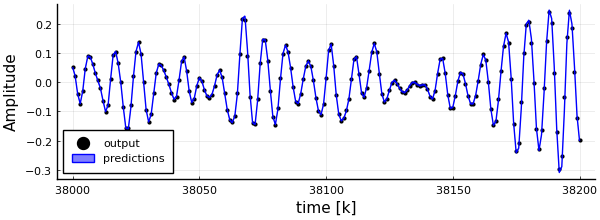

In [33]:
zoom_t = 38000:38200

p5a = scatter(zoom_t, output_tst[zoom_t], color="black", label="output", markersize=2, xlabel="time [k]", ylabel="Amplitude")
plot!(zoom_t, predictions_RLS[zoom_t], ribbon=[std, std], color="blue", linewidth=1, label="predictions", size=(600,220))

In [34]:
savefig(p5a, "figures/silverbox-NARMAX-RLS-1predictions_zoom"*string(zoom_t)*".png")

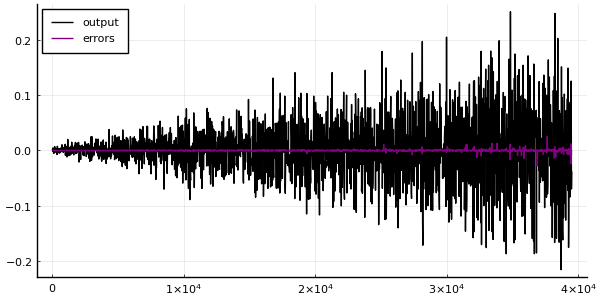

In [35]:
zoom_t = 1:20:T_tst

errors = output_tst .- predictions_RLS

p5b = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, label="output")
plot!(zoom_t, errors[zoom_t], color="purple", linewidth=1, label="errors", size=(600,300))

In [36]:
savefig(p5b, "figures/silverbox-NARMAX-RLS-1predictions_errors_zoom"*string(zoom_t)*".png")

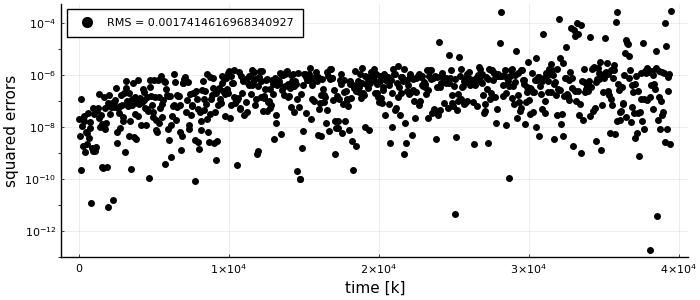

In [37]:
zoom_t = 10:50:T_tst

p3c = scatter(zoom_t, 
             sqerrors_prd_RLS[zoom_t], 
             color="black", 
             markersize=4, 
             size=(700,300), 
             xlabel="time [k]", 
             ylabel="squared errors",
             labels="RMS = "*string(RMS_prd_RLS),
             yscale=:log10)

In [38]:
savefig(p3c, "figures/silverbox-NARMAX-RLS-1predictions_sqerrors_zoom"*string(zoom_t)*".png")

### Simulation error

In [39]:
simulations_RLS = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = simulations_RLS[k-1:-1:k-M2]
    e_kmin1 = zeros(M3,)

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    simulations_RLS[k] = w_k'*ϕx

end

sqerrors_sim_RLS = (simulations_RLS[1] .- output_tst).^2
RMS_sim_RLS = sqrt(mean(sqerrors_sim_RLS))

0.054104214572741435

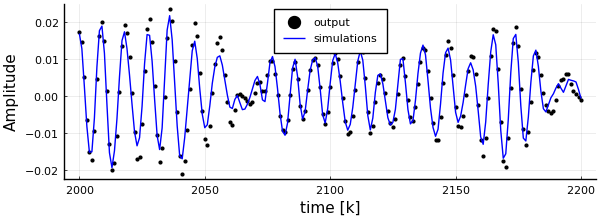

In [40]:
zoom_t = 2000:2200

p6a = scatter(zoom_t, output_tst[zoom_t], color="black", label="output", markersize=2, xlabel="time [k]", ylabel="Amplitude")
plot!(zoom_t, simulations_RLS[zoom_t], color="blue", linewidth=1, label="simulations", size=(600,220))

In [41]:
savefig(p6a, "figures/silverbox-NARMAX-RLS-simulations_zoom"*string(zoom_t)*".png")

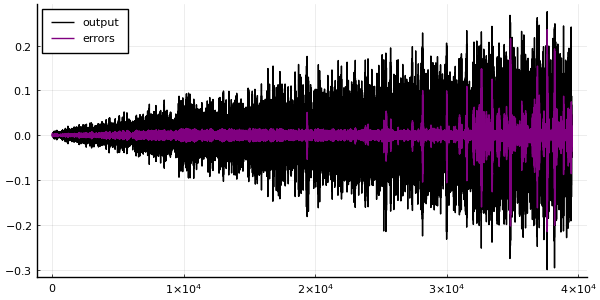

In [42]:
zoom_t = 1:T_tst

errors = output_tst .- simulations_RLS

p6b = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, label="output")
plot!(zoom_t, errors[zoom_t], color="purple", linewidth=1, label="errors", size=(600,300))

In [43]:
savefig(p6b, "figures/silverbox-NARMAX-RLS-simulations_errors_zoom"*string(zoom_t)*".png")

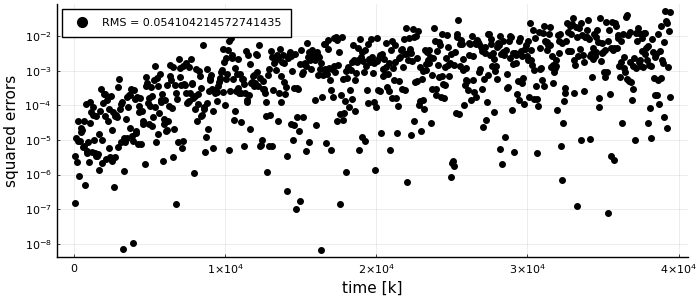

In [44]:
zoom_t = 10:50:T_tst

p6c = scatter(zoom_t, 
              sqerrors_sim_RLS[zoom_t], 
              color="black", 
              markersize=4, 
              size=(700,300), 
              xlabel="time [k]", 
              ylabel="squared errors",
              labels="RMS = "*string(RMS_sim_RLS),
              yscale=:log10)

In [45]:
savefig(p6c, "figures/silverbox-NARMAX-RLS-simulations_sqerrors_zoom"*string(zoom_t)*".png")

In [46]:
# Write results to file
save("results/silverbox-NARMAX-RLS_order"*string(M)*"_results.jld", 
     "weights", w_k, 
     "simulations_RLS", simulations_RLS, 
     "predictions_RLS", predictions_RLS,
     "RMS_sim_RLS", RMS_sim_RLS,
     "RMS_prd_RLS", RMS_prd_RLS)

## Baseline: Iterative least-squares

In [47]:
results = matread("results/silverbox-NARMAX-ILS_order"*string(M)*"_results.mat");

predictions_ILS = results["yPredIterTest"]
simulations_ILS = results["ySimIterTest"]

sqerrors_prd_ILS = (output_tst[maxM+1:end] .- predictions_ILS).^2
sqerrors_sim_ILS = (output_tst[maxM+1:end] .- simulations_ILS).^2

RMS_prd_ILS = sqrt(mean(sqerrors_prd_ILS))
RMS_sim_ILS = sqrt(mean(sqerrors_sim_ILS))

NaN

## Comparisons

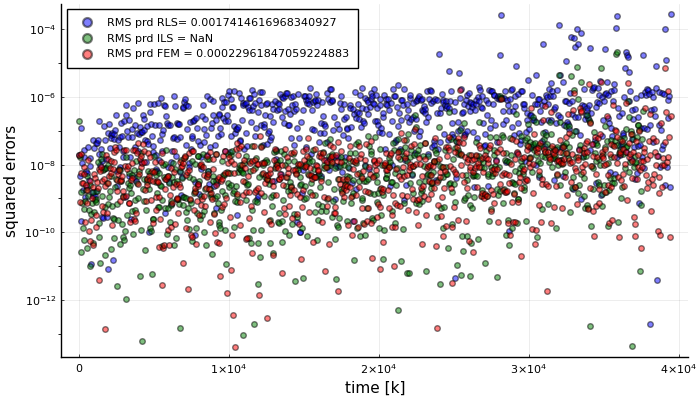

In [48]:
# Comparing 1-step ahead prediction errors between PEM and FEM
p10a = scatter(zoom_t, 
              sqerrors_prd_RLS[zoom_t], 
              color="blue", 
              alpha=0.5,
              markersize=4, 
              size=(700,400), 
              yscale=:log10,
              xlabel="time [k]", 
              ylabel="squared errors",
              label="RMS prd RLS= "*string(RMS_prd_RLS),
              legend=:topleft)
scatter!(zoom_t, 
         sqerrors_prd_ILS[zoom_t], 
         color="green", 
         alpha=0.5,
         markersize=4,
         labels="RMS prd ILS = "*string(RMS_prd_ILS))
scatter!(zoom_t, 
         sqerrors_prd_FEM[zoom_t], 
         color="red", 
         alpha=0.5,
         markersize=4,
         labels="RMS prd FEM = "*string(RMS_prd_FEM))

In [49]:
savefig(p10a, "figures/silverbox-NARMAX-comparison-sqerrors-prd.png")

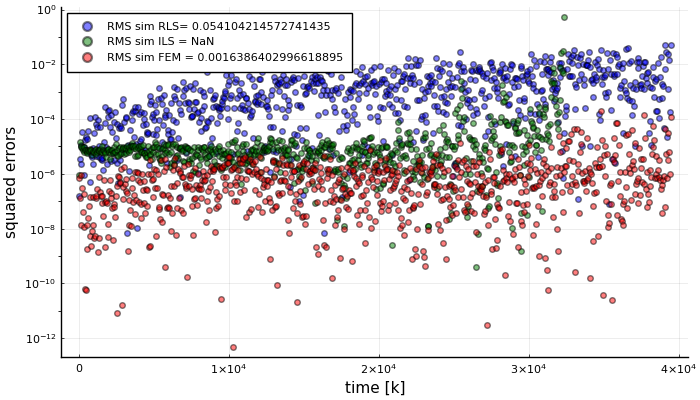

In [50]:
# Comparing 1-step ahead prediction errors between PEM and FEM
p10b = scatter(zoom_t, 
              sqerrors_sim_RLS[zoom_t], 
              color="blue", 
              alpha=0.5,
              markersize=4, 
              size=(700,400), 
              yscale=:log10,
              xlabel="time [k]", 
              ylabel="squared errors",
              label="RMS sim RLS= "*string(RMS_sim_RLS),
              legend=:topleft)
scatter!(zoom_t, 
         sqerrors_sim_ILS[zoom_t], 
         color="green", 
         alpha=0.5,
         markersize=4,
         labels="RMS sim ILS = "*string(RMS_sim_ILS))
scatter!(zoom_t, 
         sqerrors_sim_FEM[zoom_t], 
         color="red", 
         alpha=0.5,
         markersize=4,
         labels="RMS sim FEM = "*string(RMS_sim_FEM))

In [51]:
savefig(p10b, "figures/silverbox-NARMAX-comparison-sqerrors-sim.png")